In [69]:
!pip install torch
!pip install intel-extension-for-pytorch
!pip install -U datasets

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [72]:
# DEPENDENCIES
from torchvision import datasets, models, transforms
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torchvision
import os
import intel_extension_for_pytorch as ipex

In [73]:
os.listdir("data")

['sf',
 '.ipynb_checkpoints',
 'train_old',
 'validation',
 'validation_old',
 'train']

In [74]:
# https://www.kaggle.com/code/pmigdal/transfer-learning-with-resnet-50-in-pytorch
data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
    ]),
}

In [94]:
#os.listdir("data/train")
#os.removedirs("data/train/.ipynb_checkpoints")
#os.listdir("data/train")
#os.removedirs("data/validation/.ipynb_checkpoints")

In [95]:
image_datasets = {
    'train': 
    datasets.ImageFolder('data/train', data_transforms['train']),
    'validation': 
    datasets.ImageFolder('data/validation', data_transforms['validation'])
}

In [96]:
dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'], batch_size=32, shuffle=True),
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'], batch_size=32)
}

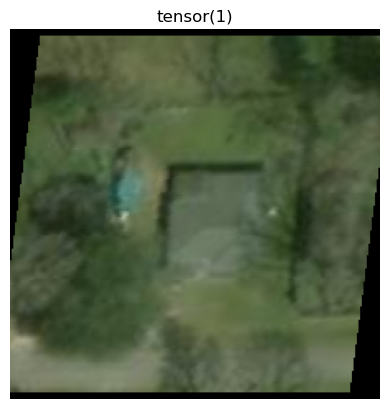

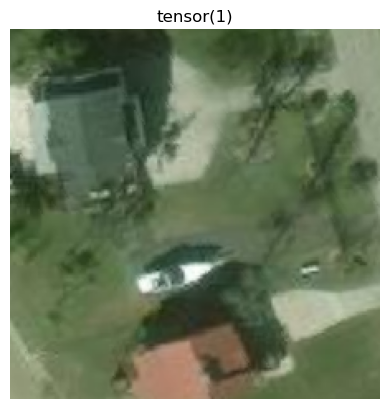

In [97]:
for batch in dataloaders["train"]:
    images, labels = batch
    # Assuming 'images' is a tensor of shape (batch_size, channels, height, width)
    # Convert the tensor to NumPy array and transpose it to (batch_size, height, width, channels)
    images_np = images.numpy().transpose(0, 2, 3, 1)
    
    # Display each image in the batch
    for i, img_np in enumerate(images_np[:2]):
        plt.title(labels[i])
        plt.imshow(img_np)
        plt.axis('off')  # Turn off axis
        plt.show()

    break

In [98]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [99]:
model = models.resnet50(pretrained=True).to(device)

/opt/intel/oneapi/intelpython/latest/envs/pytorch-gpu/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/intel/oneapi/intelpython/latest/envs/pytorch-gpu/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [100]:
for param in model.parameters():
    param.requires_grad = False   
    
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
                nn.Linear(128, 64),
               nn.ReLU(inplace=True),
               nn.Linear(64, 2)).to(device)

In [101]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

In [102]:
model, optimizer = ipex.optimize(model, optimizer=optimizer)

In [103]:
def train_model(model, criterion, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                with torch.cpu.amp.autocast():
                    inputs = inputs.to(device)
                    labels = labels.to(device)
    
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
    
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
    return model

In [104]:
model_trained = train_model(model, criterion, optimizer, num_epochs=5)

Epoch 1/5
----------
train loss: 0.3647, acc: 0.8508
validation loss: 0.7300, acc: 0.6491
Epoch 2/5
----------
train loss: 0.2254, acc: 0.9118
validation loss: 0.1731, acc: 0.9364
Epoch 3/5
----------
train loss: 0.2493, acc: 0.8993
validation loss: 0.2136, acc: 0.9072
Epoch 4/5
----------
train loss: 0.1633, acc: 0.9314
validation loss: 0.1995, acc: 0.9189
Epoch 5/5
----------
train loss: 0.1739, acc: 0.9265
validation loss: 0.2823, acc: 0.8706


In [56]:
torch.save(model_trained.state_dict(), 'models/weights.h5')

In [67]:
# Test the model
model = models.resnet50(pretrained=False).to(device)
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
                nn.Linear(128, 64),
               nn.ReLU(inplace=True),
               nn.Linear(64, 2)).to(device)
model.load_state_dict(torch.load('models/weights.h5'))

/opt/intel/oneapi/intelpython/latest/envs/pytorch-gpu/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [88]:
img_paths = ["data/sf/1 (394).jpg", "data/sf/marker1-nodamage.jpg"]
img_list = [Image.open(img_path) for img_path in img_paths]

In [89]:
validation_batch = torch.stack([data_transforms['validation'](img).to(device) for img in img_list])

In [90]:
pred_logits_tensor = model(validation_batch)
pred_logits_tensor

tensor([[ 0.4483,  0.6720],
        [ 0.7226, -0.0704]], grad_fn=<AddmmBackward0>)

In [91]:
pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()
pred_probs

array([[0.44430584, 0.5556941 ],
       [0.6884703 , 0.3115297 ]], dtype=float32)

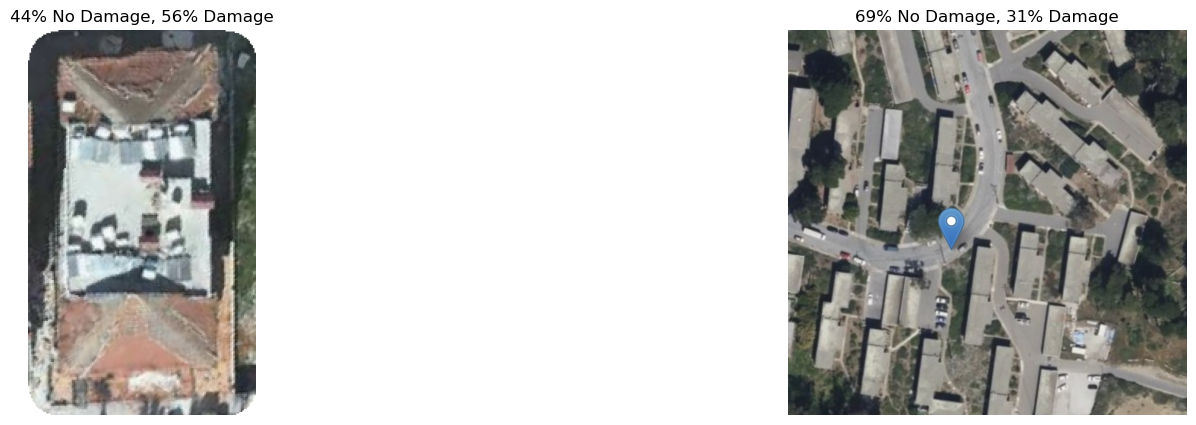

In [93]:
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% No Damage, {:.0f}% Damage".format(100*pred_probs[i,0],
                                                            100*pred_probs[i,1]))
    ax.imshow(img)